In [54]:

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [65]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
from fig5utils import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Dropbox/data_for_running/initial_clusters_400k.pt')
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_cluster

Loading components...
Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_11863/444055268.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/Dr

In [93]:
checkpoint_path = '/Users/sarahurbut/Dropbox/enrollment_model_W0.0001_jointphi.pt'
#checkpoint_path = '/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_10000/model.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

mu_dt = torch.load(checkpoint_path)['prevalence_t']


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_11863/3297767217.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/var

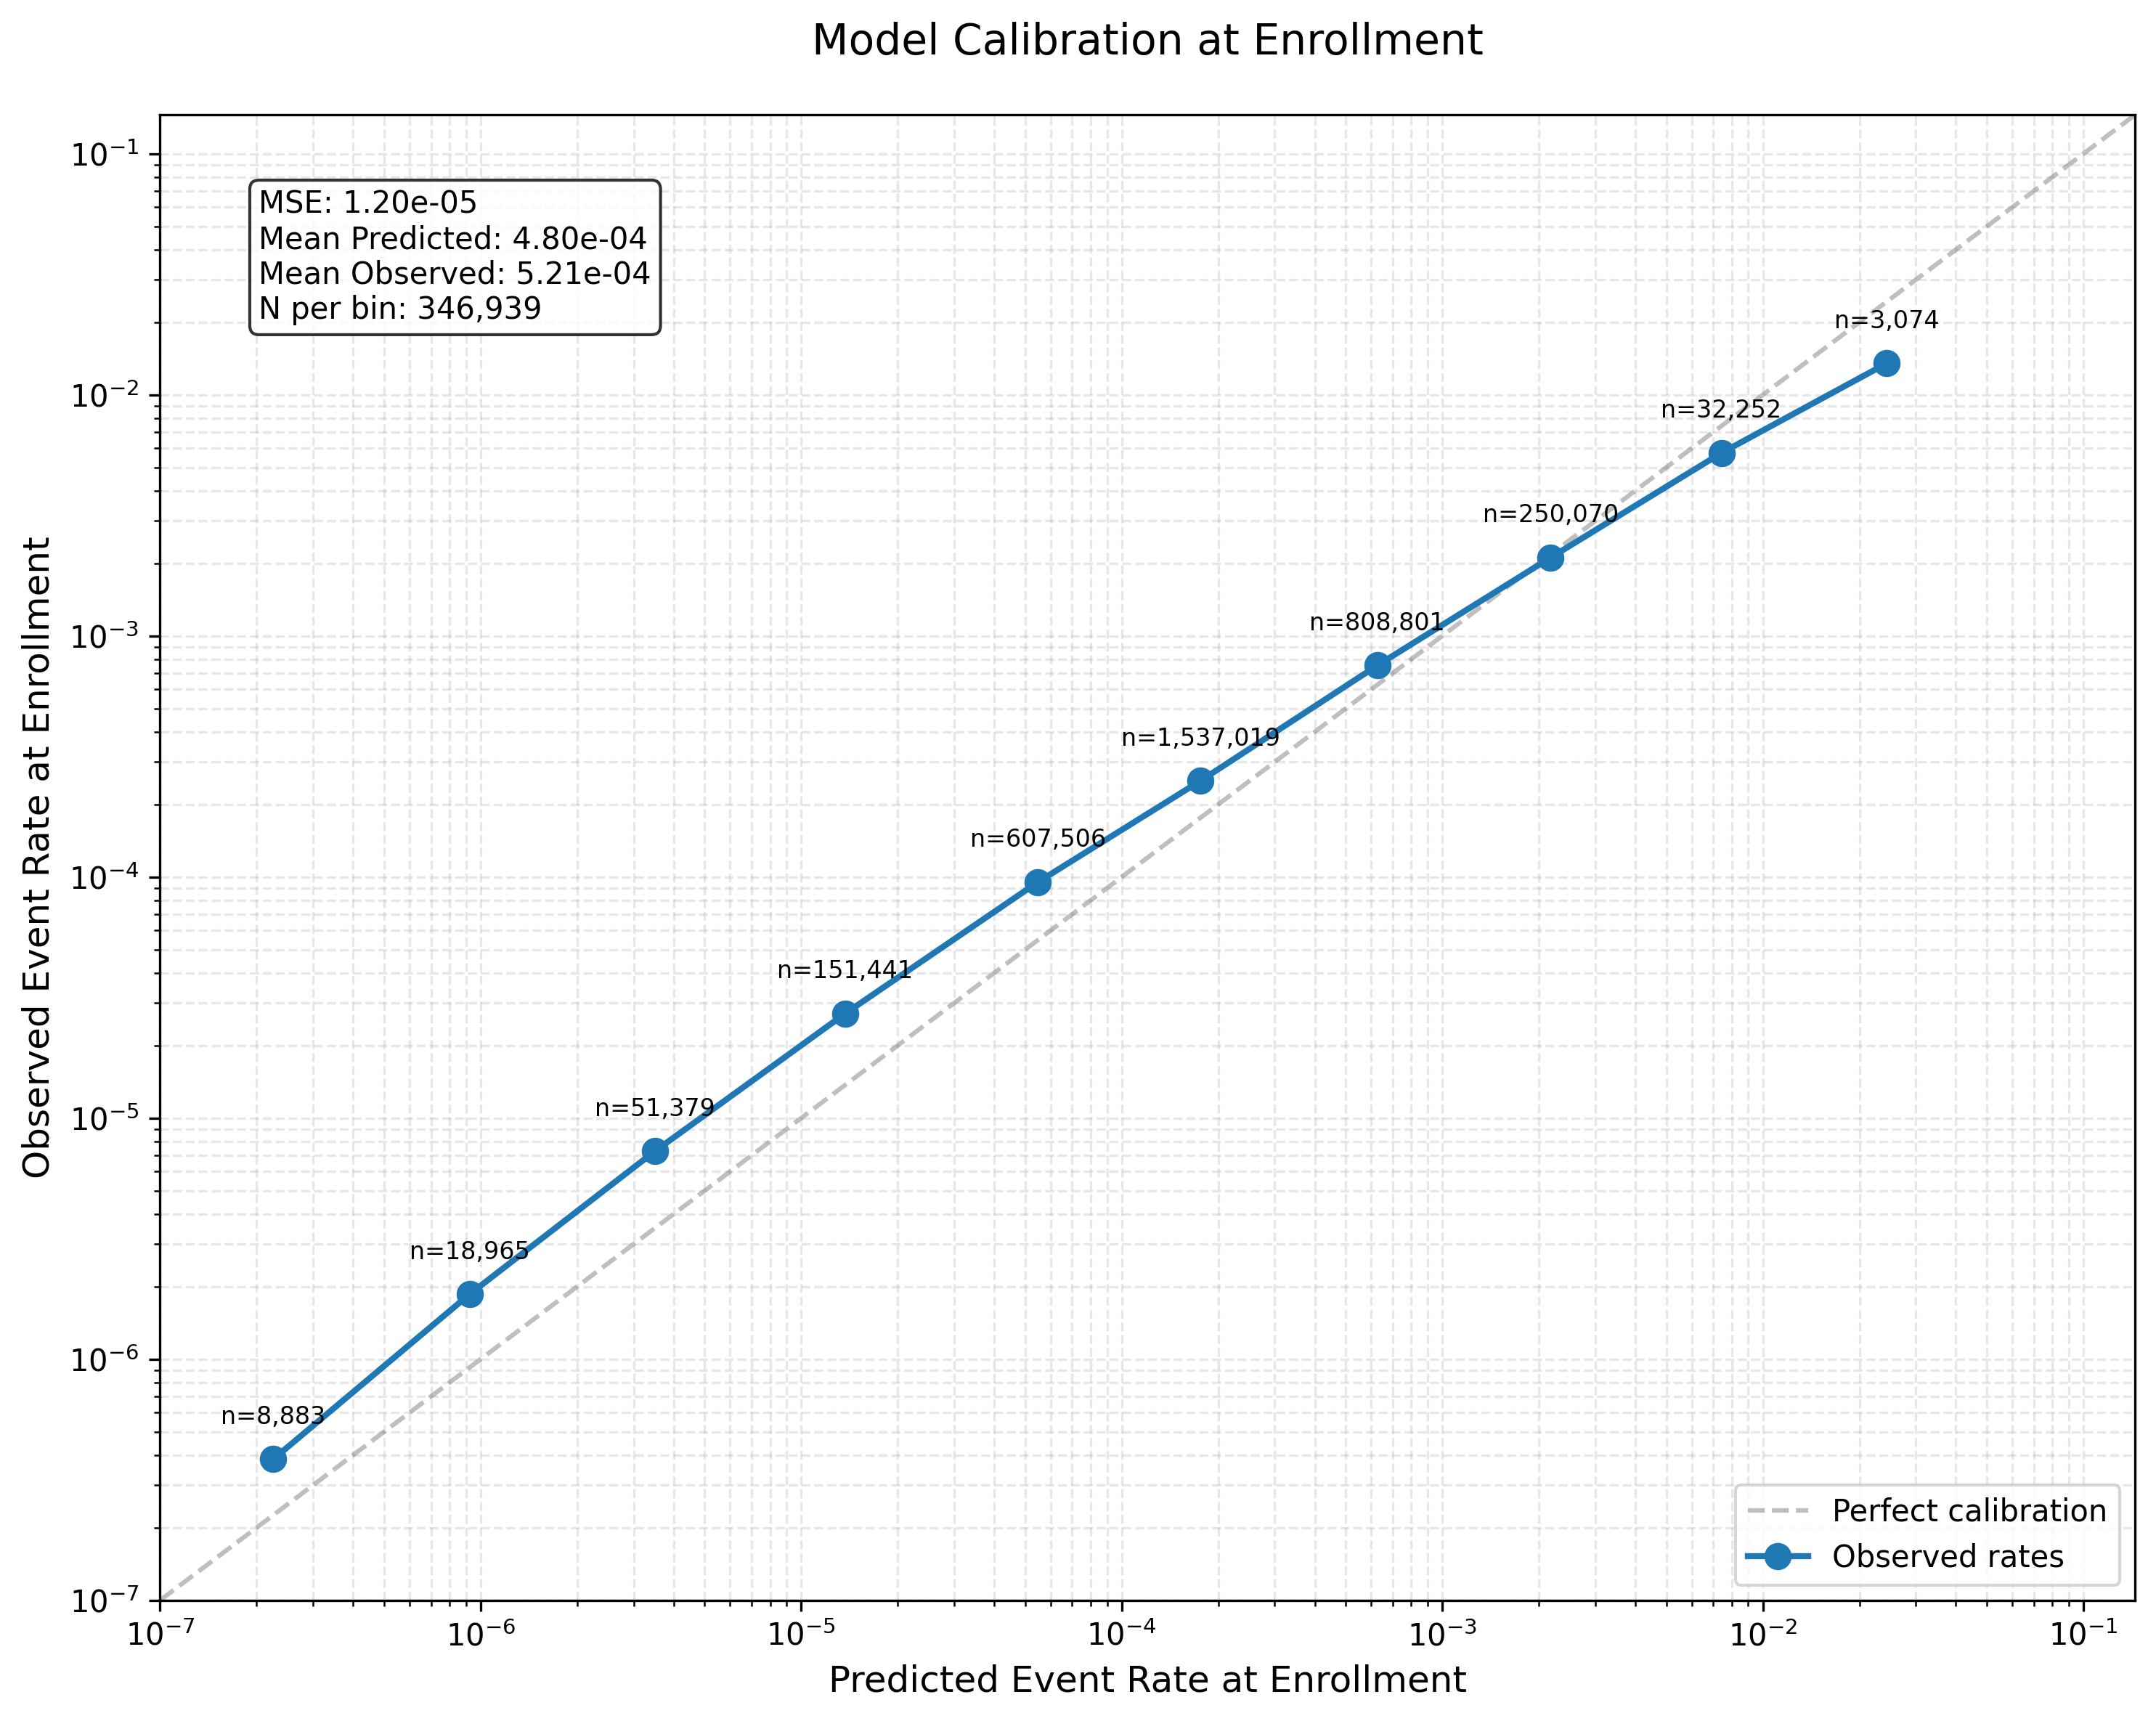

In [87]:
from fig5utils import *
fig = create_traditional_calibration_plot(
    checkpoint_path=checkpoint_path,
    #Y=checkpoint['Y'],
    cov_df=pce_df,
    mu_dt=checkpoint['prevalence_t'], 
    n_bins=10,
    save_path='/Users/sarahurbut/aladynoulli2/pyScripts/figures_for_science/figure5/calibration_plot.pdf' # smoothed prevalence rates
    #use_log_scale=True
)

In [96]:
# Example calls:
from fig5utils import *
# Evaluate using default 10-year outcome window
results_10yr = evaluate_major_diseases_wsex(model, Y_100k, E_100k, model.disease_names, pce_df) 



Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.6950077951933207 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.6268843745905619 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.6775832471127147 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 10000 individuals)

Evaluating CKD (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.7074956428998136 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)

Evaluating All_Cancers (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.636

In [101]:
from fig5utils import *
# 1. Define Train Indices 
train_indices = np.arange(20000, 30000) # Example

# 2. Define Test Data (using Y_100k and FH_processed subset aligned to it)
Y_test_eval = Y_100k 
fh_processed=pd.read_csv('/Users/sarahurbut/Dropbox/baselinagefamh.csv')
FH_test_eval = fh_processed.iloc[0:10000] # Make sure FH_test_eval aligns with Y_100k

# 3. Set Follow-up duration
follow_up = 10

fitted_models = fit_cox_baseline_models(
    Y_full=Y,  # Your full Y tensor
    FH_processed=fh_processed,  # Your processed family history DataFrame
    train_indices=np.arange(20000, 30000),  # Training indices
    disease_mapping=disease_mapping,  # Dictionary mapping disease groups to FH columns
    major_diseases=major_diseases,  # Dictionary of disease groups and their names
    disease_names=disease_names,  # List of all disease names
    follow_up_duration_years=10  # Optional: follow-up duration in years
)


Fitting Cox models using training indices [20000:30000]...
 - Fitting ASCVD...
   Model fitted for ASCVD using 20000 samples.
 - Fitting Diabetes...
   Model fitted for Diabetes using 20000 samples.
 - Atrial_Fib: No FH columns, fitting Sex only.
 - Fitting Atrial_Fib...
   Model fitted for Atrial_Fib using 10000 samples.
 - CKD: No FH columns, fitting Sex only.
 - Fitting CKD...
   Model fitted for CKD using 10000 samples.
 - All_Cancers: No FH columns, fitting Sex only.
 - Fitting All_Cancers...
   Model fitted for All_Cancers using 30000 samples.
 - Fitting Stroke...
   Model fitted for Stroke using 10000 samples.
 - Fitting Heart_Failure...
   Model fitted for Heart_Failure using 10000 samples.
 - Pneumonia: No FH columns, fitting Sex only.
 - Fitting Pneumonia...
   Model fitted for Pneumonia using 30000 samples.
 - COPD: No FH columns, fitting Sex only.
 - Fitting COPD...
   Model fitted for COPD using 10000 samples.
 - Osteoporosis: No FH columns, fitting Sex only.
 - Fitting Os

In [102]:

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message="DataFrame Index is not unique")
test_results = evaluate_cox_baseline_models(
    fitted_models=fitted_models,  # The models we just fitted
    Y_test=Y_100k,  # Test portion of Y tensor
    FH_test=fh_processed.iloc[0:10000],  # Test portion of FH data
    disease_mapping=disease_mapping,
    major_diseases=major_diseases,
    disease_names=disease_names,
    follow_up_duration_years=10  # Should match the training duration
)


Evaluating Cox models on test data...
 - Evaluating ASCVD...
   C-index: 0.650 (0.634-0.670)
   Events: 708/20000
 - Evaluating Diabetes...
   C-index: 0.606 (0.585-0.628)
   Events: 598/20000
 - Evaluating Atrial_Fib...
   C-index: 0.582 (0.553-0.611)
   Events: 376/10000
 - Evaluating CKD...
   C-index: 0.555 (0.511-0.596)
   Events: 104/10000
 - Evaluating All_Cancers...
   C-index: 0.615 (0.586-0.642)
   Events: 322/30000
 - Evaluating Stroke...
   C-index: 0.540 (0.471-0.631)
   Events: 49/10000
 - Evaluating Heart_Failure...
   C-index: 0.589 (0.517-0.658)
   Events: 84/10000
 - Evaluating Pneumonia...
   C-index: 0.561 (0.534-0.585)
   Events: 377/30000
 - Evaluating COPD...
   C-index: 0.535 (0.505-0.567)
   Events: 272/10000
 - Evaluating Osteoporosis...
   C-index: 0.644 (0.613-0.671)
   Events: 219/10000
 - Evaluating Anemia...
   C-index: 0.549 (0.515-0.577)
   Events: 272/10000
 - Evaluating Colorectal_Cancer...
   C-index: 0.477 (0.419-0.535)
   Events: 75/10000
 - Evalu

In [103]:
aladynoulli_results = evaluate_major_diseases_wsex(model, Y_100k, E_100k, disease_names, pce_df, follow_up_duration_years=10)
# 6. Evaluate Baseline Models on TEST data <-- UNCOMMENT THIS



Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.6950077951933207 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.6268843745905619 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.6775832471127147 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 10000 individuals)

Evaluating CKD (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.7074956428998136 (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)

Evaluating All_Cancers (10-Year Outcome, 1-Year Score)...
AUC (Score: 1-Yr Risk, Outcome: 10-Yr Event): 0.636

In [104]:
# Create a DataFrame to store the comparison
comparison_data = []

# Get the Aladynoulli results (assuming they're stored in a variable called aladyn_results)
# If you need help getting these, let me know!

# Get the Cox model results from test_results
cox_results=test_results
aladyn_results=aladynoulli_results


for disease, cox_results in test_results.items():
    if cox_results['c_index'] is not np.nan:  # Only include diseases where Cox model converged
        row = {
            'Disease': disease,
               'Aladynoulli C-index': aladyn_results.get(disease, {}).get('auc', 'N/A'),
            #'Aladynoulli Events': aladyn_results.get(disease, {}).get('events', 'N/A'),
        'Cox C-index': f"{cox_results['c_index']:.3f} ({cox_results['ci'][0]:.3f}-{cox_results['ci'][1]:.3f})",
            'Events': f"{cox_results['n_events']}/{cox_results['n_total']}"
            }
         
        comparison_data.append(row)

# Create DataFrame and sort by disease name
comparison_df = pd.DataFrame(comparison_data).sort_values('Disease')

# Display the table
print("\nComparison of Cox Model and Aladynoulli Performance:")
print(comparison_df.to_string(index=False))


Comparison of Cox Model and Aladynoulli Performance:
             Disease  Aladynoulli C-index         Cox C-index    Events
               ASCVD             0.695008 0.650 (0.634-0.670) 708/20000
         All_Cancers             0.636691 0.615 (0.586-0.642) 322/30000
              Anemia             0.593050 0.549 (0.515-0.577) 272/10000
             Anxiety             0.502026 0.533 (0.506-0.564) 241/10000
              Asthma             0.506082 0.519 (0.497-0.540) 606/10000
          Atrial_Fib             0.677583 0.582 (0.553-0.611) 376/10000
    Bipolar_Disorder             0.371919 0.563 (0.462-0.649)  34/10000
      Bladder_Cancer             0.724048 0.705 (0.648-0.739)  49/10000
       Breast_Cancer             0.577492 0.525 (0.483-0.568)   42/5409
                 CKD             0.707496 0.555 (0.511-0.596) 104/10000
                COPD             0.645263 0.535 (0.505-0.567) 272/10000
   Colorectal_Cancer             0.659424 0.477 (0.419-0.535)  75/10000
      Croh

In [108]:
from fig5utils import *
enrollment_df_full=pd.read_csv('/Users/sarahurbut/Dropbox/baselinagefamh.csv')
event_rate_results = calculate_enrollment_event_rates(Y, enrollment_df_full, disease_names, major_diseases)


Calculating rates for ASCVD...
  Found 2 indices: [112, 114]...
  1-Year: Count=1660, Processed=407878, Rate=0.0041
  10-Year: Count=22561, Processed=407878, Rate=0.0553

Calculating rates for Diabetes...
  Found 2 indices: [47, 48]...
  1-Year: Count=1692, Processed=407878, Rate=0.0041
  10-Year: Count=24240, Processed=407878, Rate=0.0594

Calculating rates for Atrial_Fib...
  Found 1 indices: [127]...
  1-Year: Count=926, Processed=407878, Rate=0.0023
  10-Year: Count=15558, Processed=407878, Rate=0.0381

Calculating rates for CKD...
  Found 1 indices: [230]...
  1-Year: Count=113, Processed=407878, Rate=0.0003
  10-Year: Count=4850, Processed=407878, Rate=0.0119

Calculating rates for All_Cancers...
  Found 3 indices: [10, 16, 21]...
  1-Year: Count=773, Processed=407878, Rate=0.0019
  10-Year: Count=12732, Processed=407878, Rate=0.0312

Calculating rates for Stroke...
  Found 1 indices: [135]...
  1-Year: Count=100, Processed=407878, Rate=0.0002
  10-Year: Count=2162, Processed=40

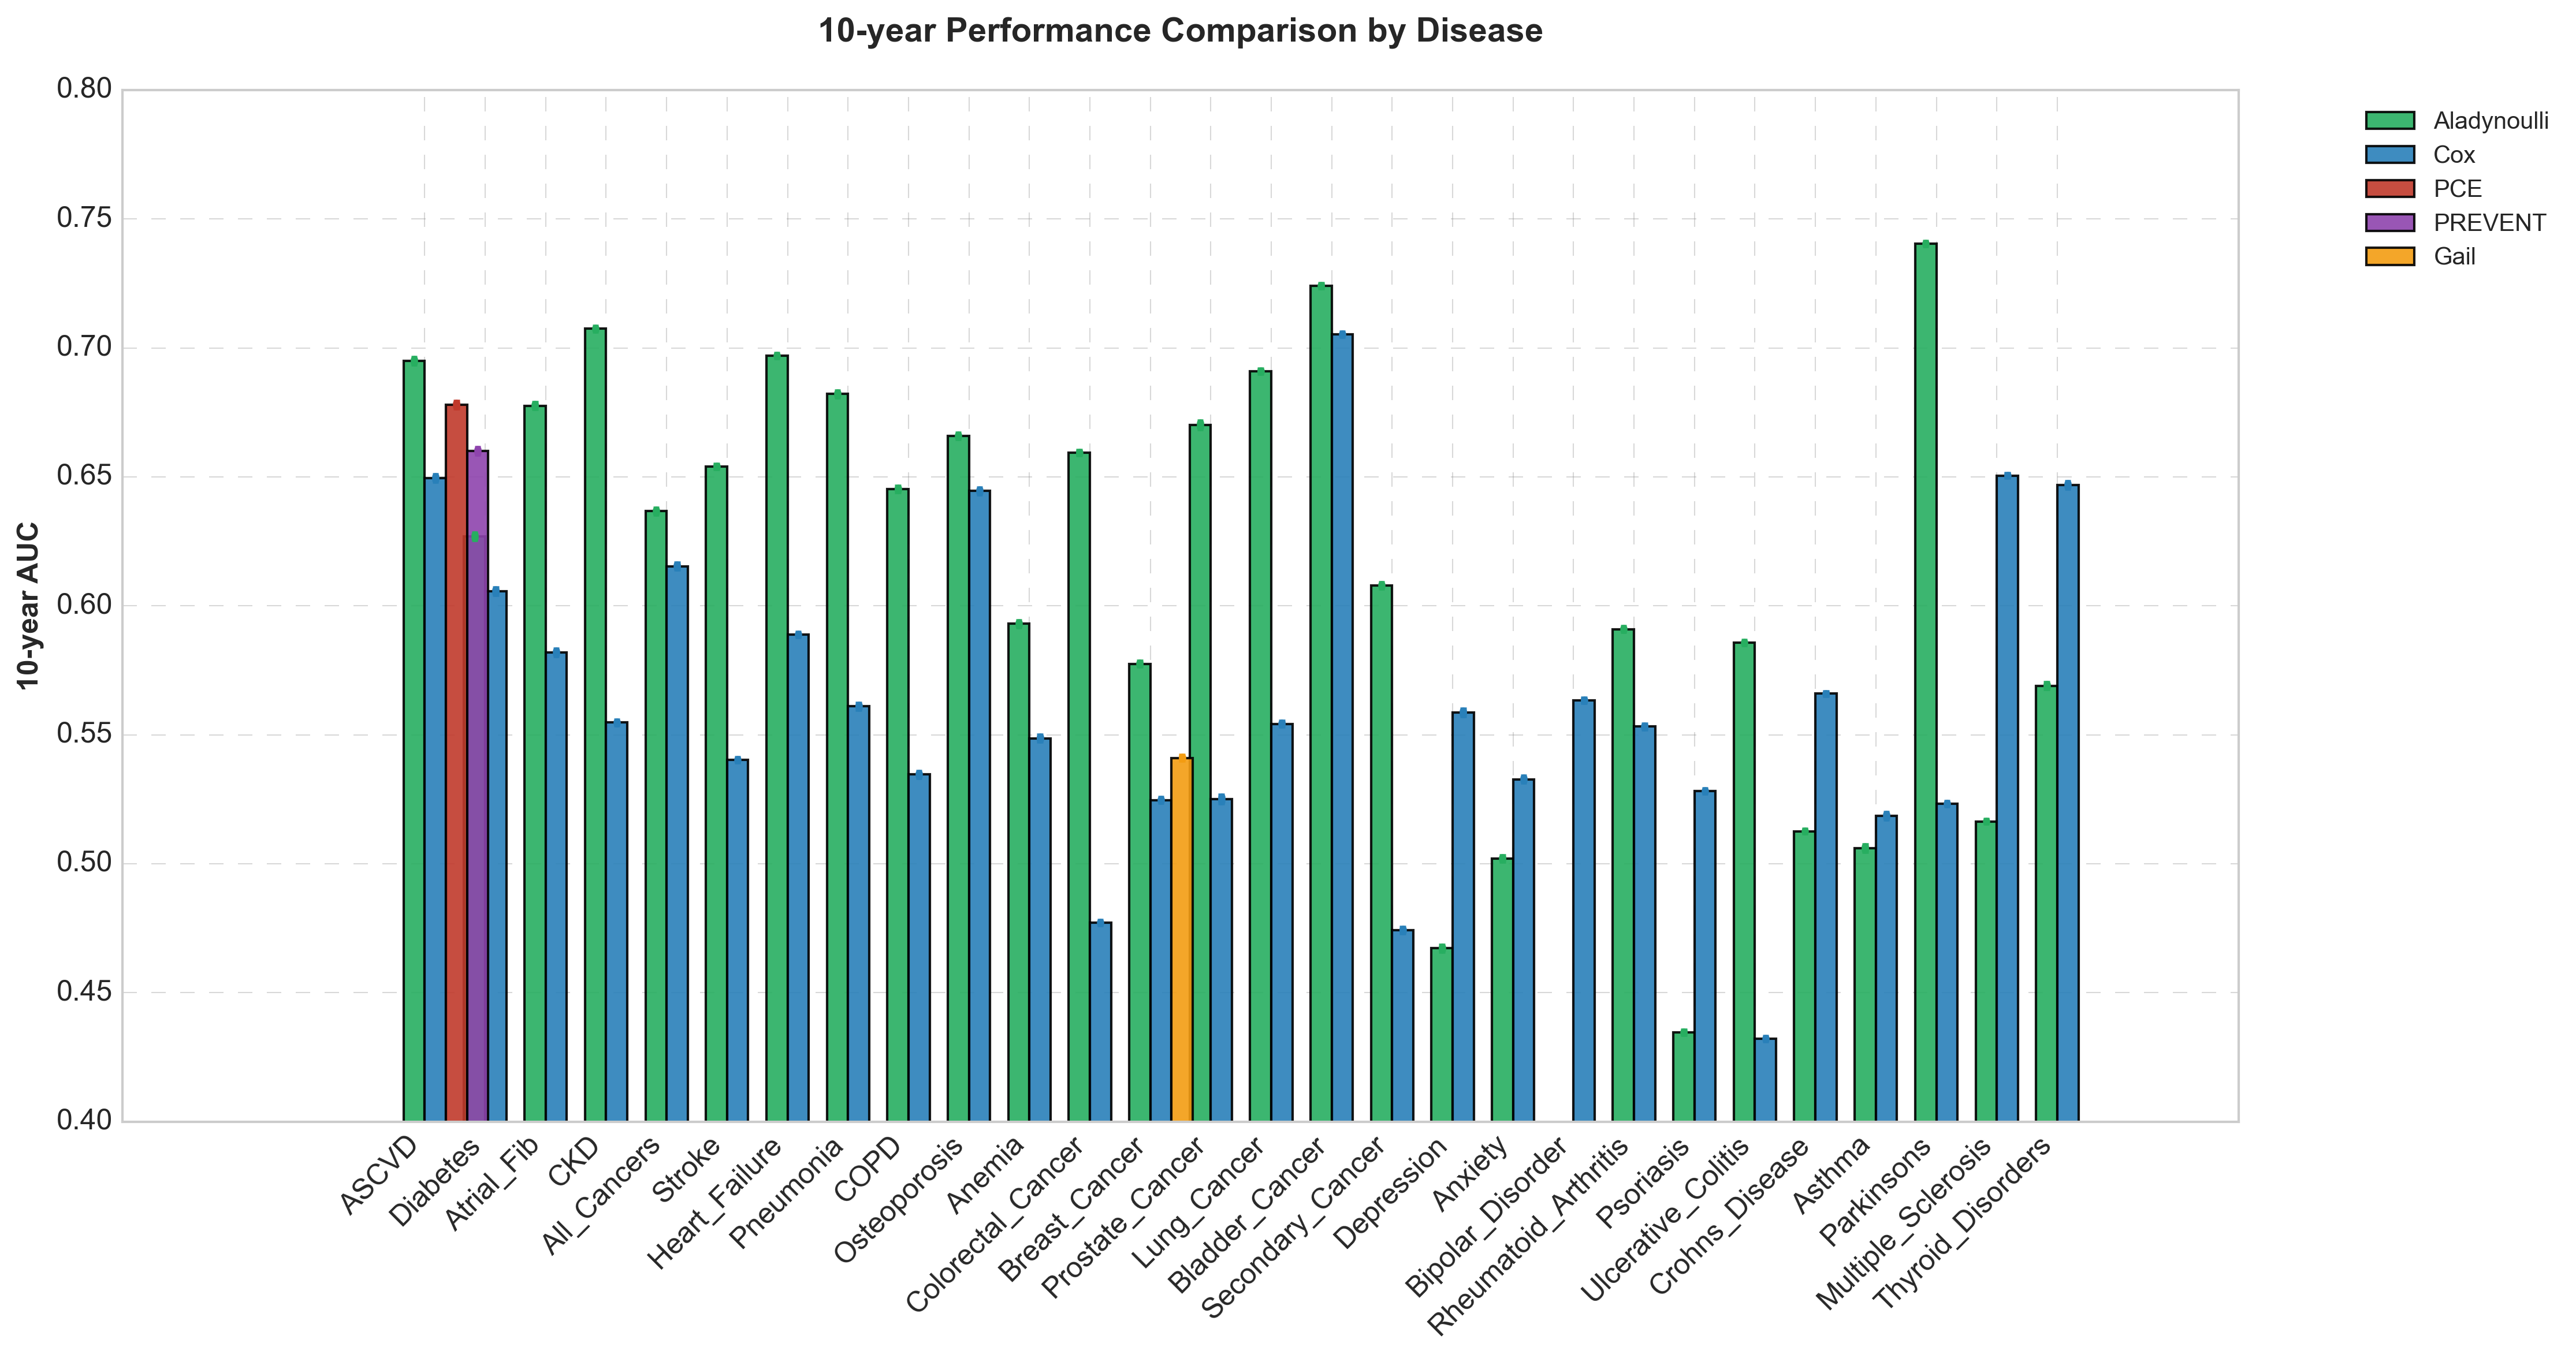

In [216]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Any 
from fig5utils import *
fig = plot_ten_year_comparison_bars(aladyn_results, 
                                    cox_results, 
                                    event_rate_results,
                                     major_diseases,
                                     save_path='/Users/sarahurbut/aladynoulli2/pyScripts/figures_for_science/figure5/ten_year_comparison_plot.pdf')

In [136]:
print("Aladynoulli results keys:", aladyn_results.keys())
print("Cox results keys:", cox_results.keys())
print("Event rate results keys:", event_rate_results.keys())

Aladynoulli results keys: dict_keys(['ASCVD', 'Diabetes', 'Atrial_Fib', 'CKD', 'All_Cancers', 'Stroke', 'Heart_Failure', 'Pneumonia', 'COPD', 'Osteoporosis', 'Anemia', 'Colorectal_Cancer', 'Breast_Cancer', 'Prostate_Cancer', 'Lung_Cancer', 'Bladder_Cancer', 'Secondary_Cancer', 'Depression', 'Anxiety', 'Bipolar_Disorder', 'Rheumatoid_Arthritis', 'Psoriasis', 'Ulcerative_Colitis', 'Crohns_Disease', 'Asthma', 'Parkinsons', 'Multiple_Sclerosis', 'Thyroid_Disorders'])
Cox results keys: dict_keys(['ASCVD', 'Diabetes', 'Atrial_Fib', 'CKD', 'All_Cancers', 'Stroke', 'Heart_Failure', 'Pneumonia', 'COPD', 'Osteoporosis', 'Anemia', 'Colorectal_Cancer', 'Breast_Cancer', 'Prostate_Cancer', 'Lung_Cancer', 'Bladder_Cancer', 'Secondary_Cancer', 'Depression', 'Anxiety', 'Bipolar_Disorder', 'Rheumatoid_Arthritis', 'Psoriasis', 'Ulcerative_Colitis', 'Crohns_Disease', 'Asthma', 'Parkinsons', 'Multiple_Sclerosis', 'Thyroid_Disorders'])
Event rate results keys: dict_keys(['ASCVD', 'Diabetes', 'Atrial_Fib', '

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_11863/1277519250.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkdl=torch.load("/Users/sarahurbut/Dropbox

torch.Size([10000, 348, 52])
torch.Size([10000, 348])
torch.Size([10000, 348])


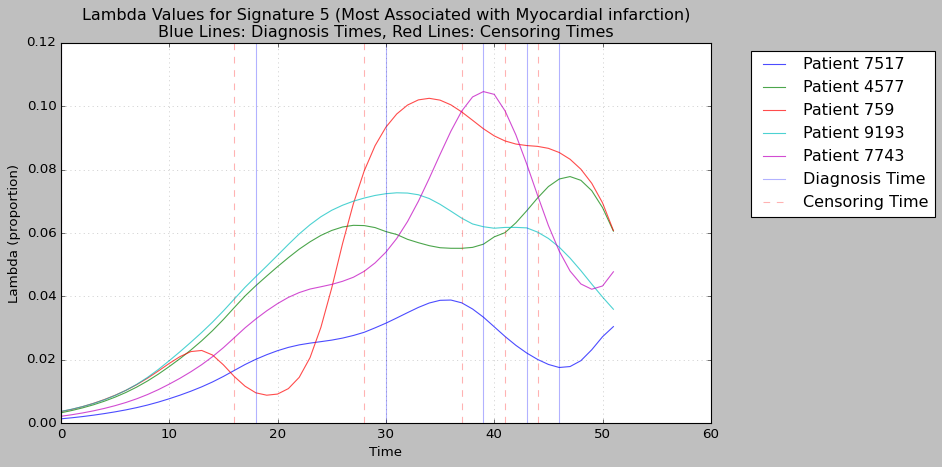

In [172]:
# Usage example:
from fig5utils import *
checkdl=torch.load("/Users/sarahurbut/Dropbox/model_with_kappa_bigam_2.pt")
model_dl=model
model_dl.load_state_dict(checkdl['model_state_dict'])

ascvd_indices = [111, 112, 113, 114, 115, 116]
print(Y_100k.shape)
print(E_100k.shape)
# Create censored event times
E_censored, censored_indices, original_event_times = create_censored_event_times(
     Y_100k, E_100k, ascvd_indices=ascvd_indices, censoring_window=2
)
print(E_censored.shape)


Y_test=Y_100k
patient_info = plot_disease_lambda_alignment_for_test(
     model_dl, Y_test, censored_indices, original_event_times, 
     disease_idx=112  # MI
)

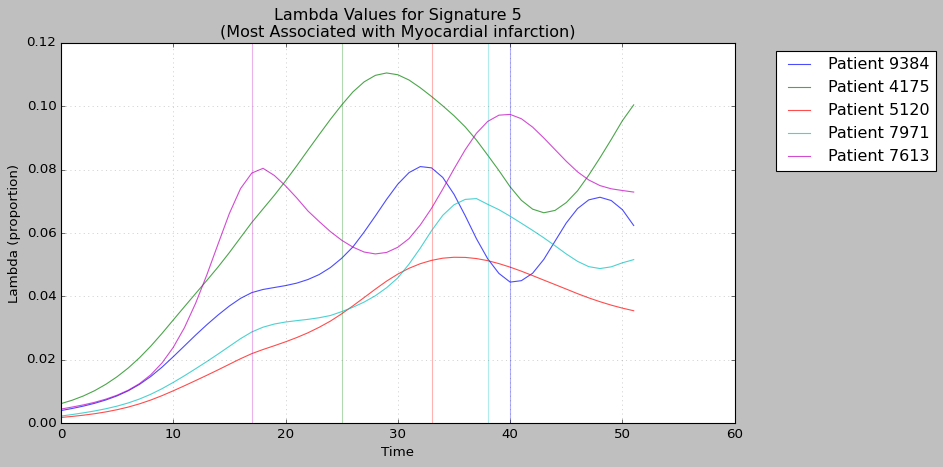

In [210]:
# List of patients to analyze
from fig5utils import *
patients = [9384, 4175, 5120, 7971, 7613]

# Create the plot
fig = analyze_specific_patients(model_dl, patients,
save_pdf='/Users/sarahurbut/aladynoulli2/pyScripts/figures_for_science/figure5/specific_patients_plot.pdf')


Analyzing Unstable Angina...
Found 198 cases and 100 controls


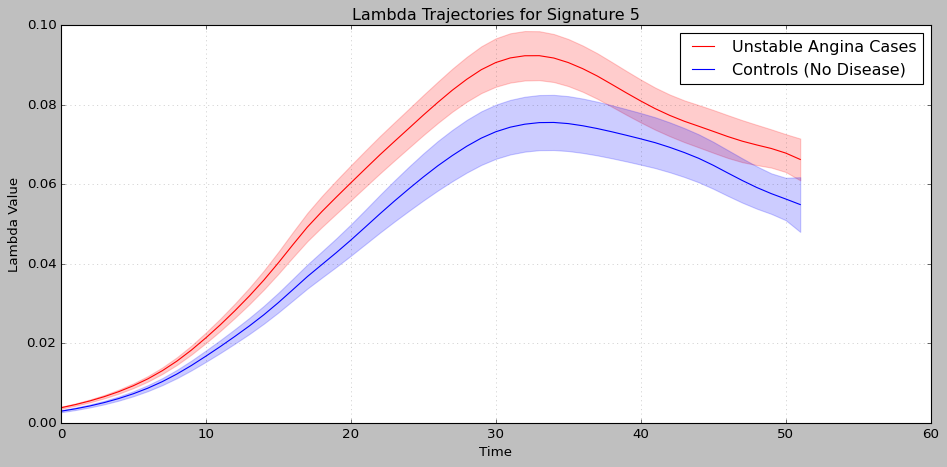

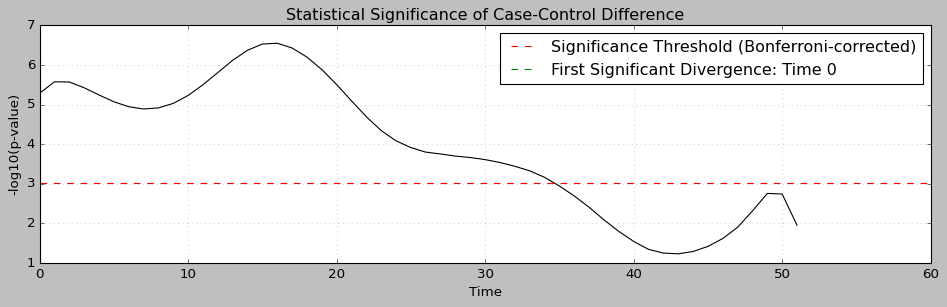

Trajectories significantly diverge at time 0
Average diagnosis time: 32.3
Average lead time: 32.3 time units

Analyzing Myocardial Infarction...
Found 635 cases and 100 controls


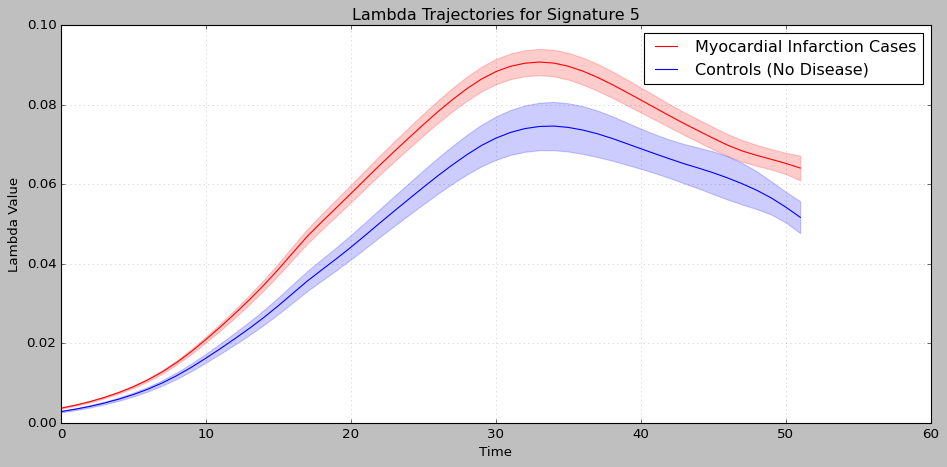

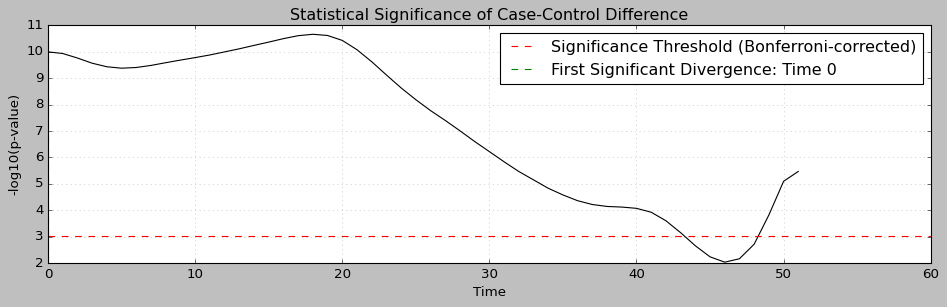

Trajectories significantly diverge at time 0
Average diagnosis time: 34.8
Average lead time: 34.8 time units

Analyzing Coronary Atherosclerosis...
Found 731 cases and 100 controls


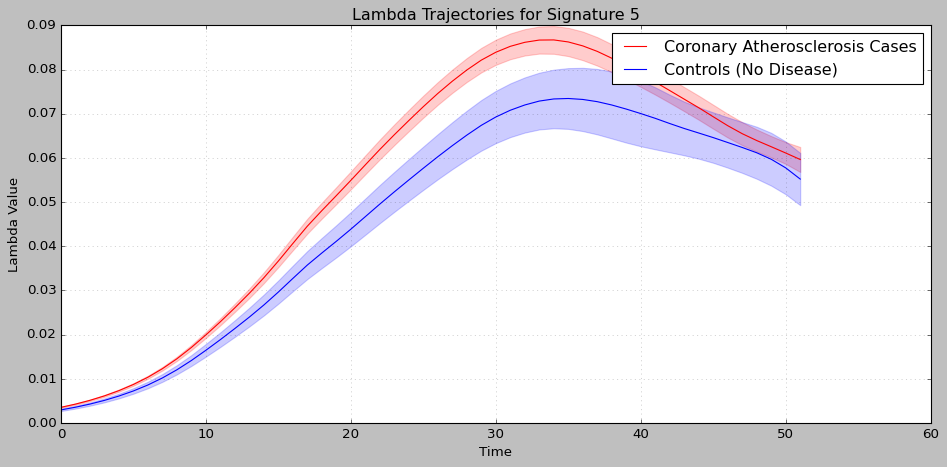

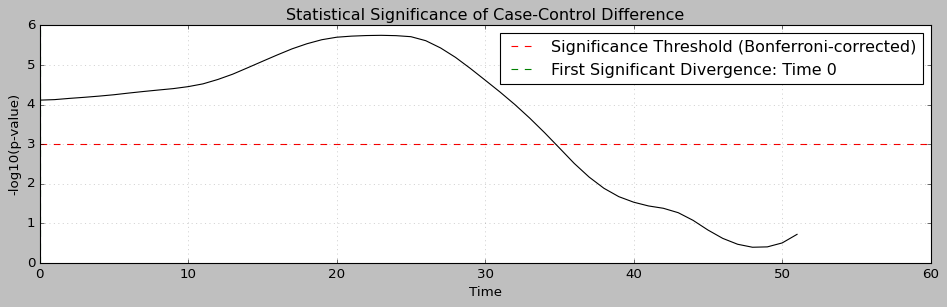

Trajectories significantly diverge at time 0
Average diagnosis time: 34.3
Average lead time: 34.3 time units

Analyzing Other Chronic Ischemic Heart Disease...
Found 847 cases and 100 controls


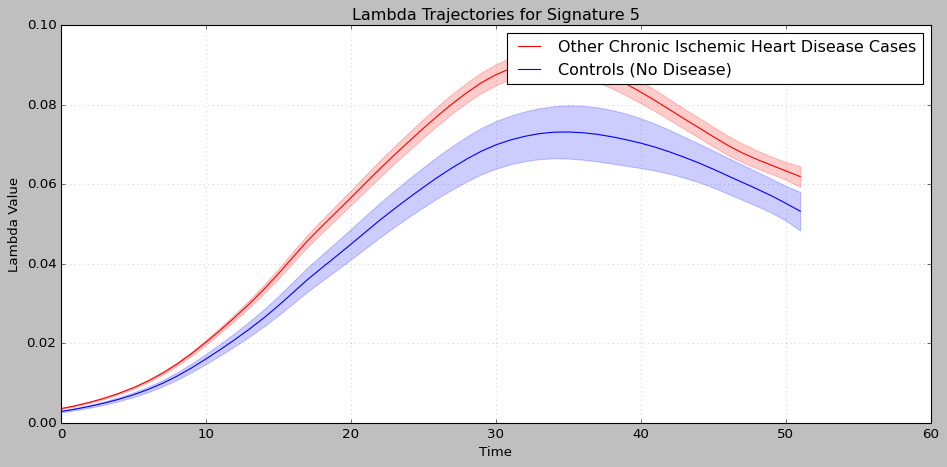

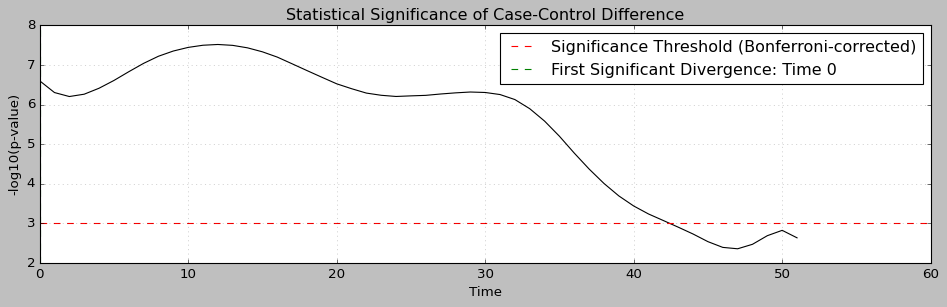

Trajectories significantly diverge at time 0
Average diagnosis time: 34.3
Average lead time: 34.3 time units

Analyzing Heart Failure...
Found 744 cases and 100 controls


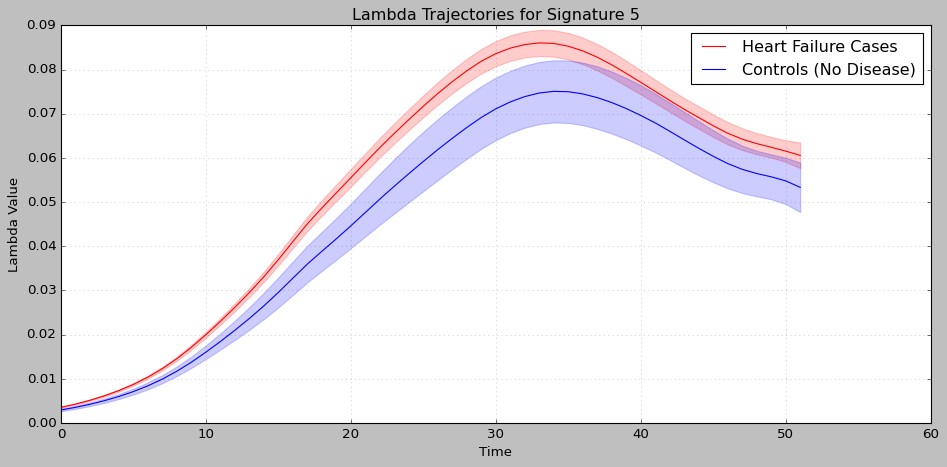

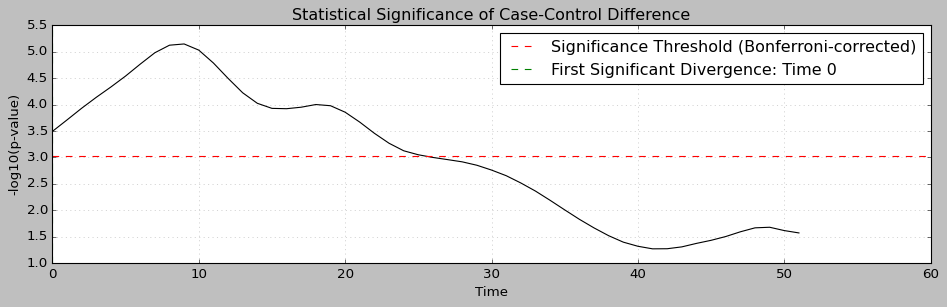

Trajectories significantly diverge at time 0
Average diagnosis time: 36.1
Average lead time: 36.1 time units

Analyzing Atrial Fibrillation...
Found 93 cases and 100 controls


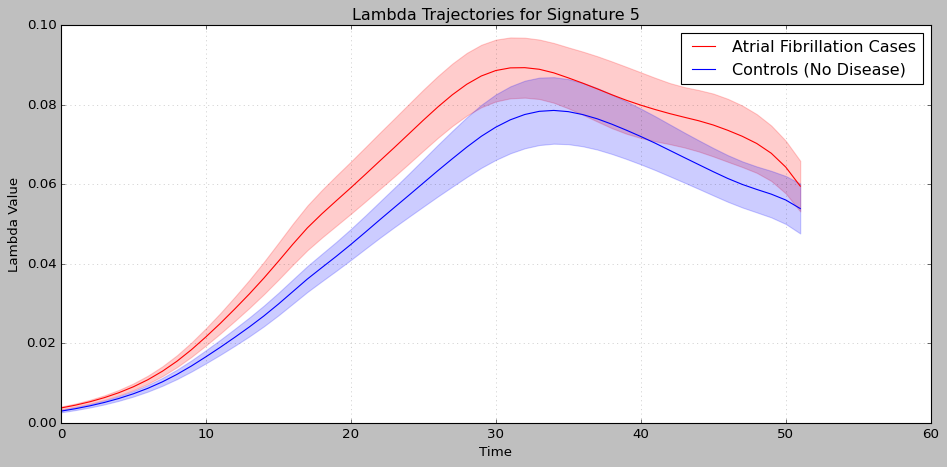

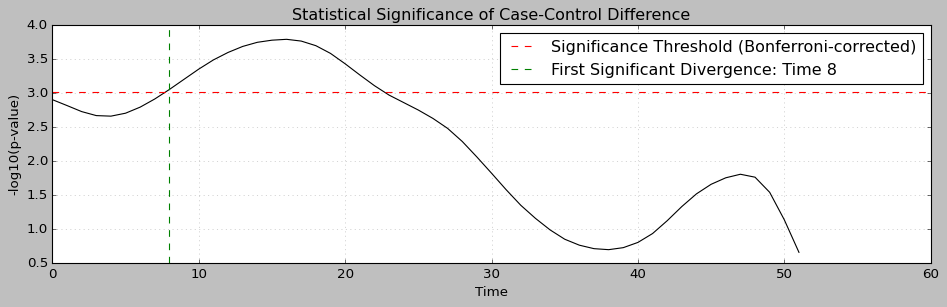

Trajectories significantly diverge at time 8
Average diagnosis time: 36.1
Average lead time: 28.1 time units


In [197]:
from  fig5utils import *
for disease_idx in [111, 112, 113, 114, 115, 116]:
    print(f"\nAnalyzing {get_disease_name(disease_idx)}...")
    compare_case_control_trajectories(model, Y_100k, disease_idx=disease_idx)

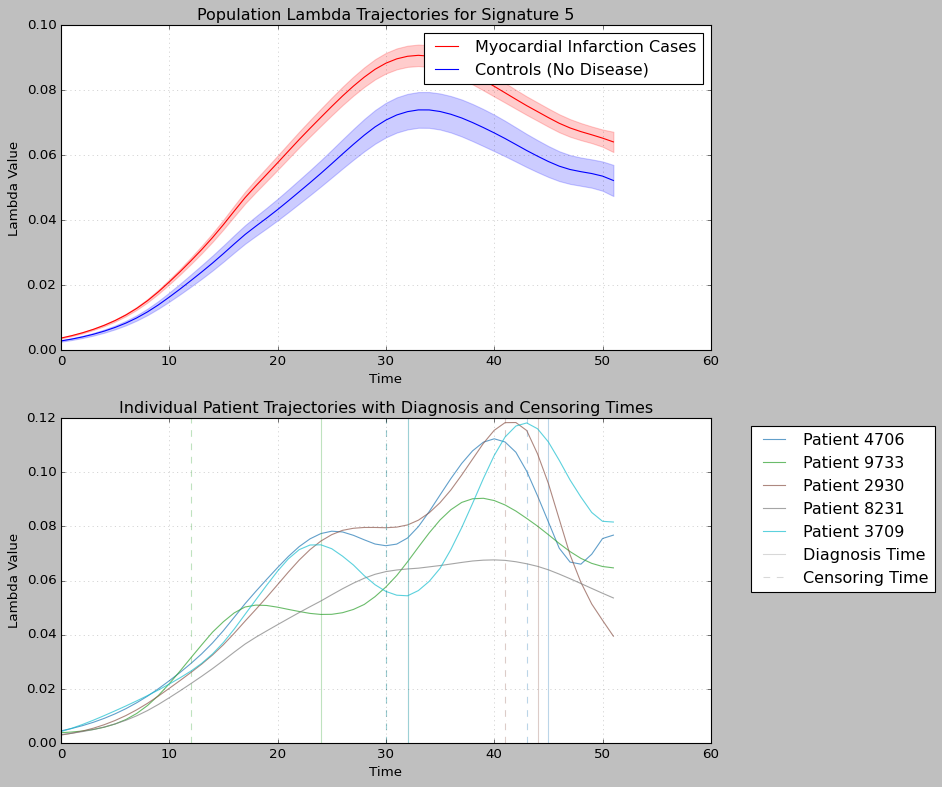

In [209]:
from fig5utils import *
fig = create_combined_mi_plots(model, Y_test, censored_indices, original_event_times)

# Optionally save to PDF
plt.savefig('/Users/sarahurbut/aladynoulli2/pyScripts/figures_for_science/figure5/mi_trajectories_combined.pdf', bbox_inches='tight', dpi=300)

/Users/sarahurbut/aladynoulli2/pyScripts/fig5utils.py:560: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(first_model_path)
/Users/sarahurbut/aladyno

Loaded prevalence_t from first model, shape: (348, 52)
Processing batches...
Processed batch 0 for predictions
Processed batch 1 for predictions
Processed batch 2 for predictions
Processed batch 3 for predictions
Processed batch 4 for predictions
Processed batch 5 for predictions
Processed batch 6 for predictions
Processed batch 7 for predictions
Processed batch 8 for predictions
Processed batch 9 for predictions
Processed batch 10 for predictions
Processed batch 11 for predictions
Processed batch 12 for predictions
Processed batch 13 for predictions
Processed batch 14 for predictions
Processed batch 15 for predictions
Processed batch 16 for predictions
Processed batch 17 for predictions
Processed batch 18 for predictions
Processed batch 19 for predictions
Processed batch 20 for predictions
Processed batch 21 for predictions
Processed batch 22 for predictions
Processed batch 23 for predictions
Processed batch 24 for predictions
Processed batch 25 for predictions
Processed batch 26 for 

(40     0.750738
 41     1.002469
 42     1.315740
 43     1.697156
 44     2.149208
 45     2.672515
 46     3.262303
 47     3.911304
 48     4.605620
 49     5.332103
 50     6.071465
 51     6.807099
 52     7.517794
 53     8.190776
 54     8.813304
 55     9.378895
 56     9.880095
 57    10.317180
 58    10.689321
 59    10.998984
 60    11.244161
 61    11.426126
 62    11.541025
 63    11.581147
 64    11.536525
 65    11.396853
 66    11.152010
 67    10.794563
 68    10.325526
 69     9.750450
 70     9.086648
 dtype: float64,
 array([0.6106291 , 0.80374641, 1.04147009, 1.32827071, 1.66611251,
        2.05595833, 2.49458643, 2.97659996, 3.4932697 , 4.03531316,
        4.58929369, 5.14383163, 5.68428096, 6.20137852, 6.68303646,
        7.12577882, 7.52172519, 7.86989079, 8.16726327, 8.41258107,
        8.60868828, 8.75227804, 8.84554198, 8.87824319, 8.84286676,
        8.7344715 , 8.54515961, 8.27067804, 7.91173073, 7.47857565,
        6.98347807]),
 array([ 0.82692488,  1.10

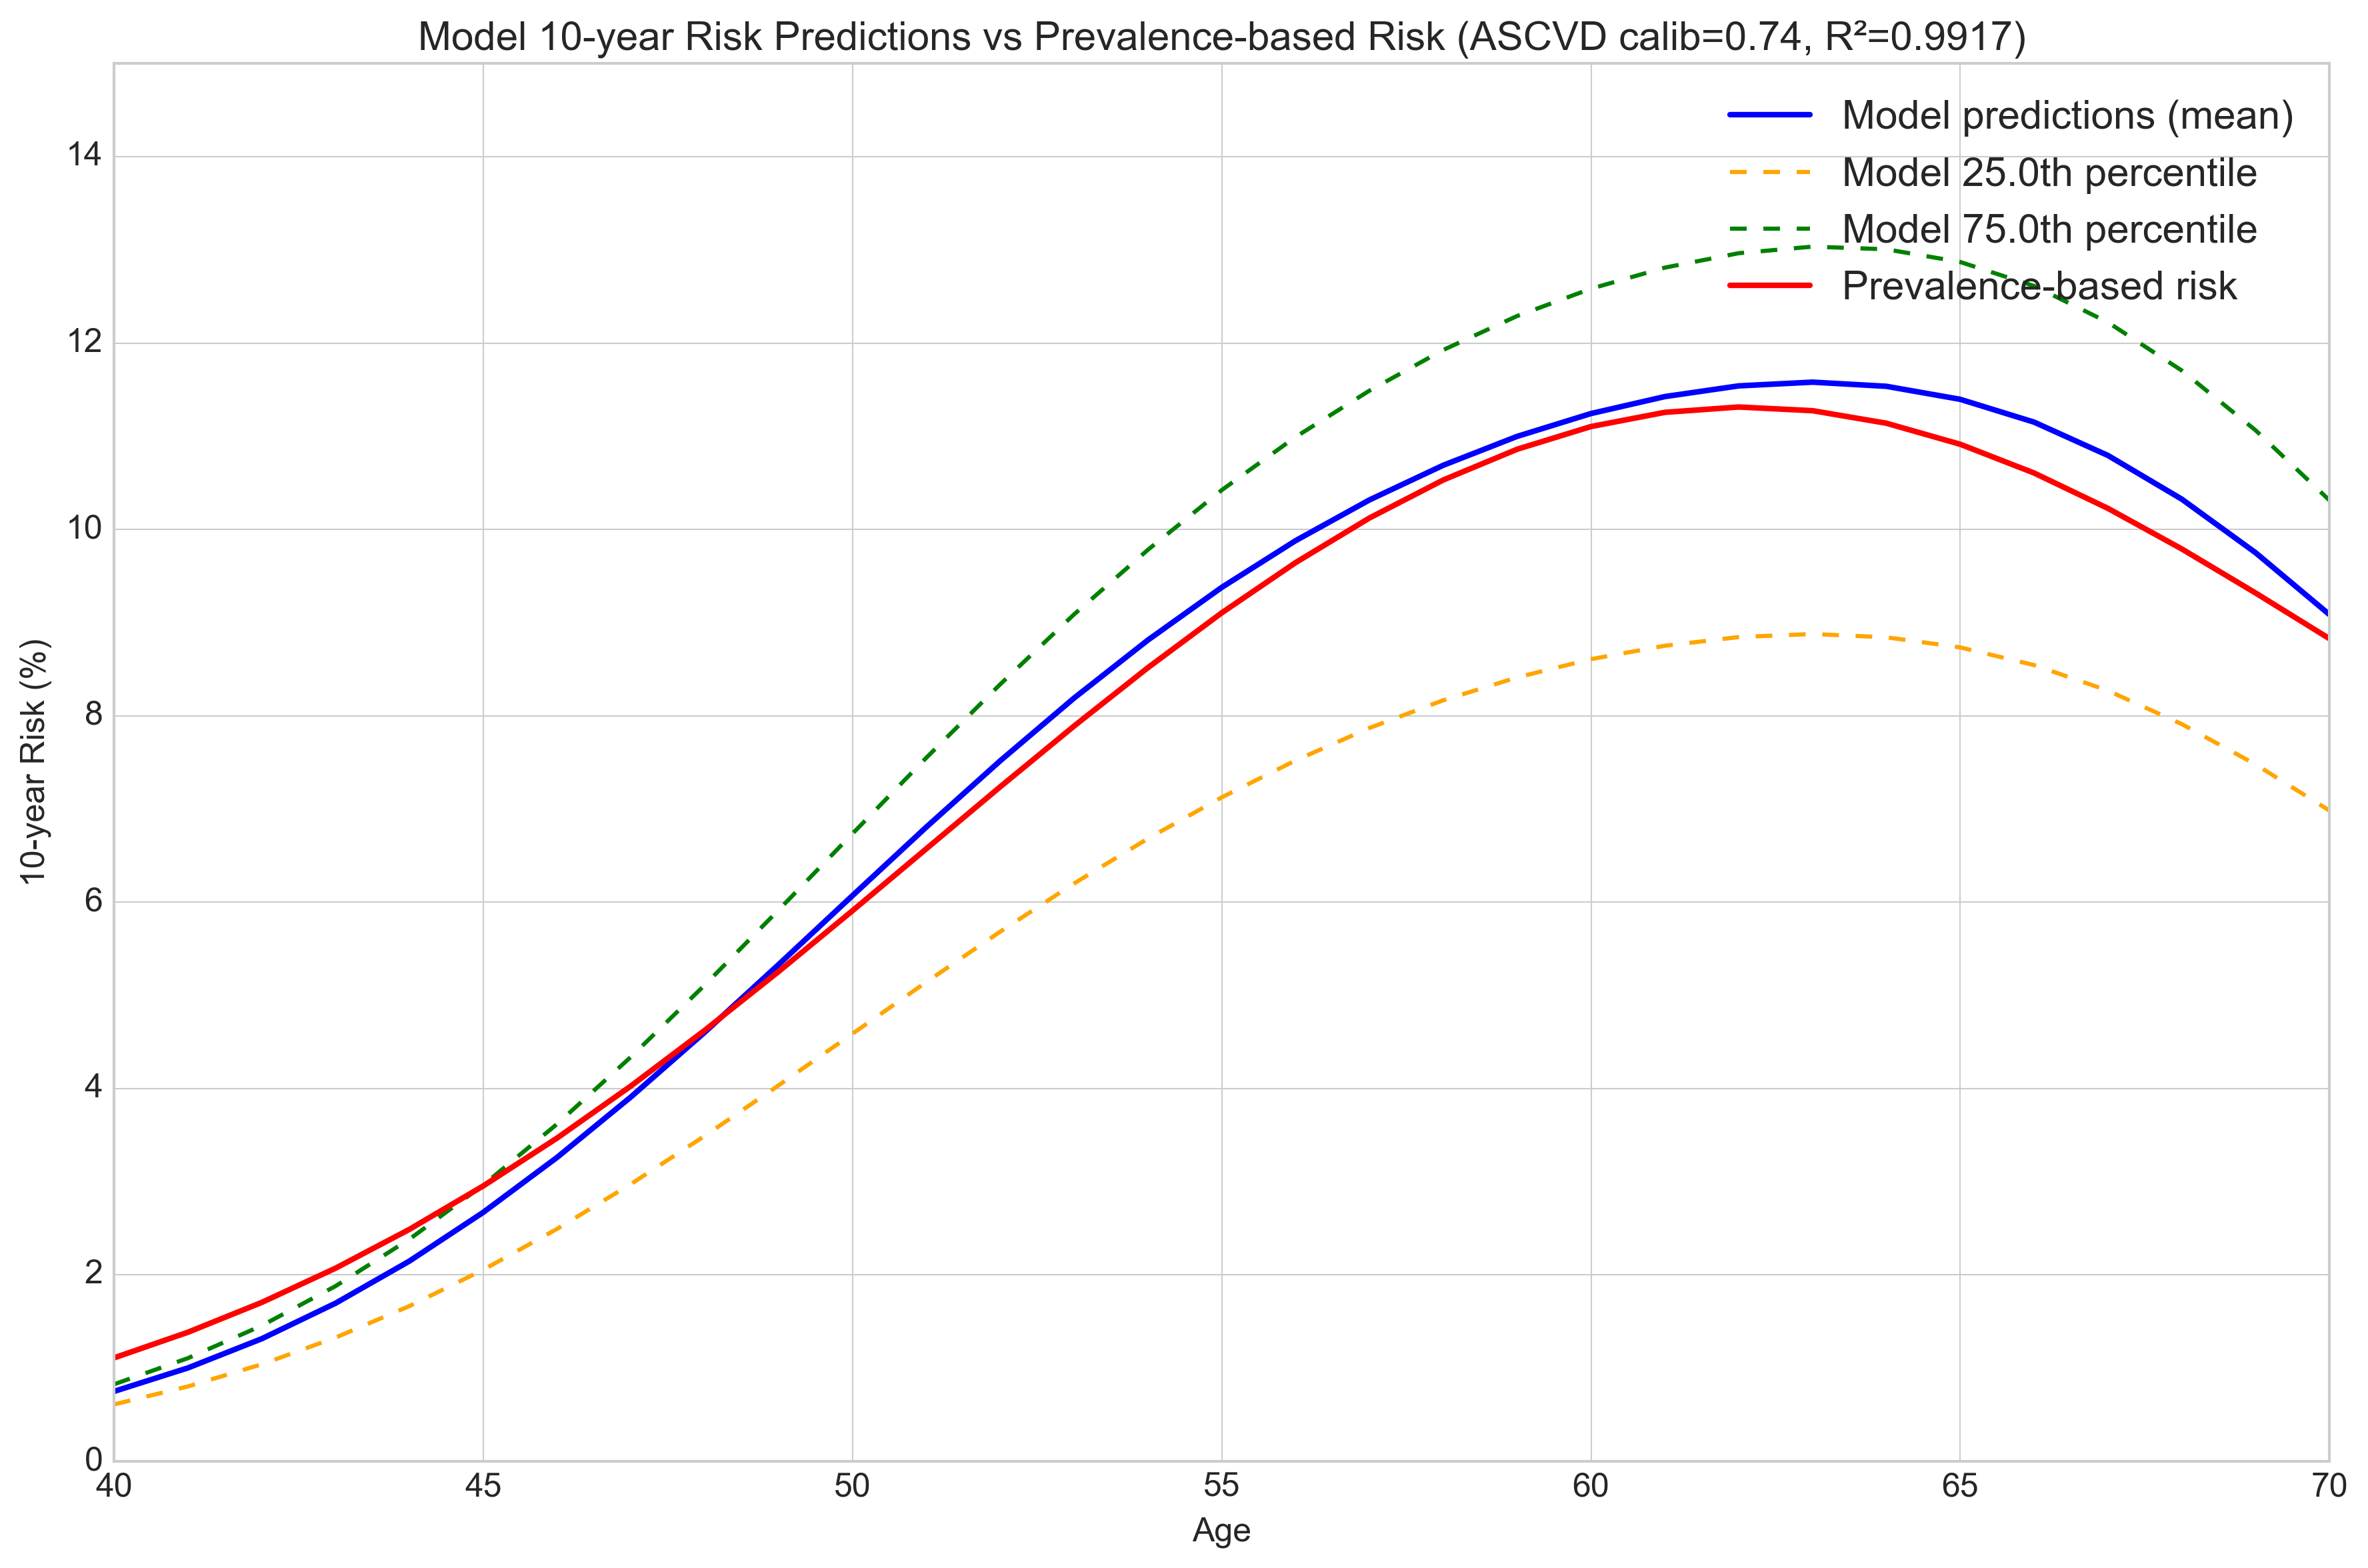

In [217]:
plot_ascvd_risk_comparison(n_batches=40, batch_size=10000, ascvd_indices=[111, 112, 113, 114, 115, 116])